## EEG Signal Exploration

### What this notebook does
### EEG Band Power Comparison

We computed EEG power over time for four frequency bands:

- **Delta (0.5–4 Hz):** deep sleep / slow waves  
- **Theta (4–8 Hz):** drowsiness / light sleep  
- **Alpha (8–12 Hz):** relaxed awake state  
- **Beta (12–30 Hz):** alert / active thinking  

The EEG was split into 2-second overlapping epochs, and PSD was computed for each band, averaging across all channels.  

The resulting plots show **how brain activity fluctuates across different states**. Peaks in beta indicate alertness, alpha peaks show relaxation, and theta/delta peaks correspond to drowsiness or slow-wave activity.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mne
from sklearn.cluster import KMeans

In [4]:
# Load the dataset
raw = mne.io.read_raw_brainvision(
   "sub-00002_ses-1_task-sleep_run-20160531_2257.vhdr",
    preload=True
)

Extracting parameters from sub-00002_ses-1_task-sleep_run-20160531_2257.vhdr...
Setting channel info structure...


C:\Users\hp\AppData\Local\Temp\ipykernel_23320\2150219817.py:2: RuntimeWarning: No coordinate information found for channels ['ECG', 'EMG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(


Reading 0 ... 396019  =      0.000 ...  1584.076 secs...


C:\Users\hp\AppData\Local\Temp\ipykernel_23320\2150219817.py:2: RuntimeWarning: Not setting positions of 2 misc channels found in montage:
['ECG', 'EMG']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_brainvision(


### Setting Channel Types

The recording contains not only EEG (brain signals) but also ECG (heart activity) and EMG (muscle activity) channels.

Here I specify the correct channel types so that MNE can treat these signals properly during visualization and analysis. This helps separate brain activity from physiological artifacts such as heartbeat and muscle movement.

In [5]:
# Set channels
raw.set_channel_types({
    "ECG": "ecg",
    "EMG": "emg"
})

C:\Users\hp\AppData\Local\Temp\ipykernel_23320\203033170.py:2: RuntimeWarning: The unit for channel(s) ECG, EMG has changed from NA to V.
  raw.set_channel_types({


<RawBrainVision | sub-00002_ses-1_task-sleep_run-20160531_2257.dat, 65 x 396020 (1584.1 s), ~196.5 MiB, data loaded>

In [6]:
# Pick only EEG channels (ignore EMG, ECG, etc.)
raw.pick_types(eeg=True)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<RawBrainVision | sub-00002_ses-1_task-sleep_run-20160531_2257.dat, 63 x 396020 (1584.1 s), ~190.4 MiB, data loaded>

### Setting EEG Reference

EEG signals are measured relative to a reference electrode. Here, we set the reference to the **average of all EEG electrodes**. 

This step ensures the signals are balanced and comparable across all channels, reducing bias from any single electrode.

In [7]:
#Apply a basic average reference
raw.set_eeg_reference('average', projection=False)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


<RawBrainVision | sub-00002_ses-1_task-sleep_run-20160531_2257.dat, 63 x 396020 (1584.1 s), ~190.4 MiB, data loaded>

### Visualizing Raw EEG Signals
Here I plot the EEG channels to observe brain wave patterns and check signal quality.

Using matplotlib as 2D backend.


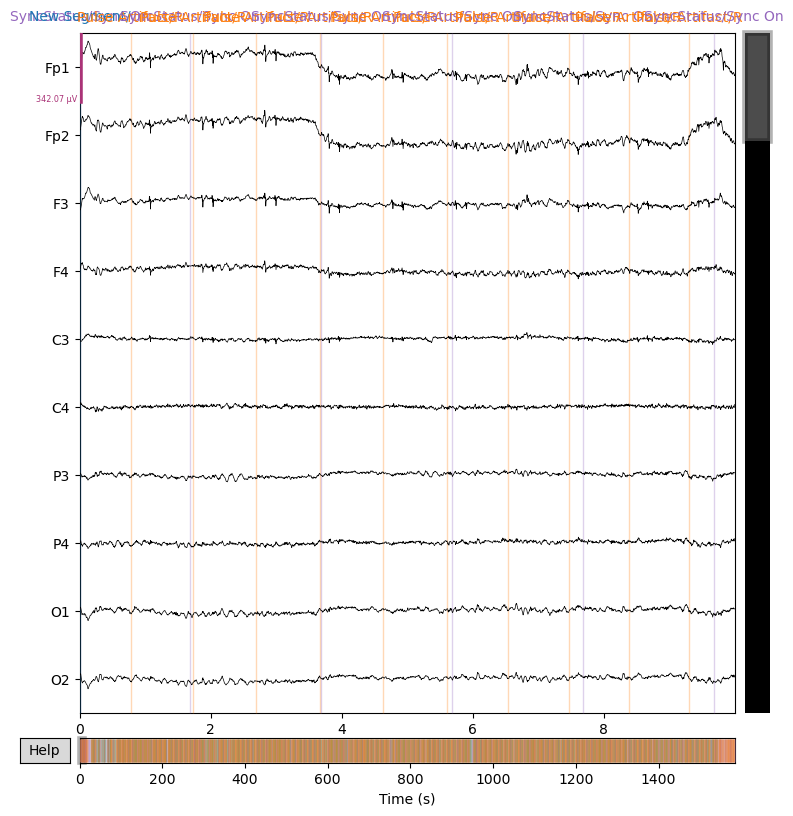

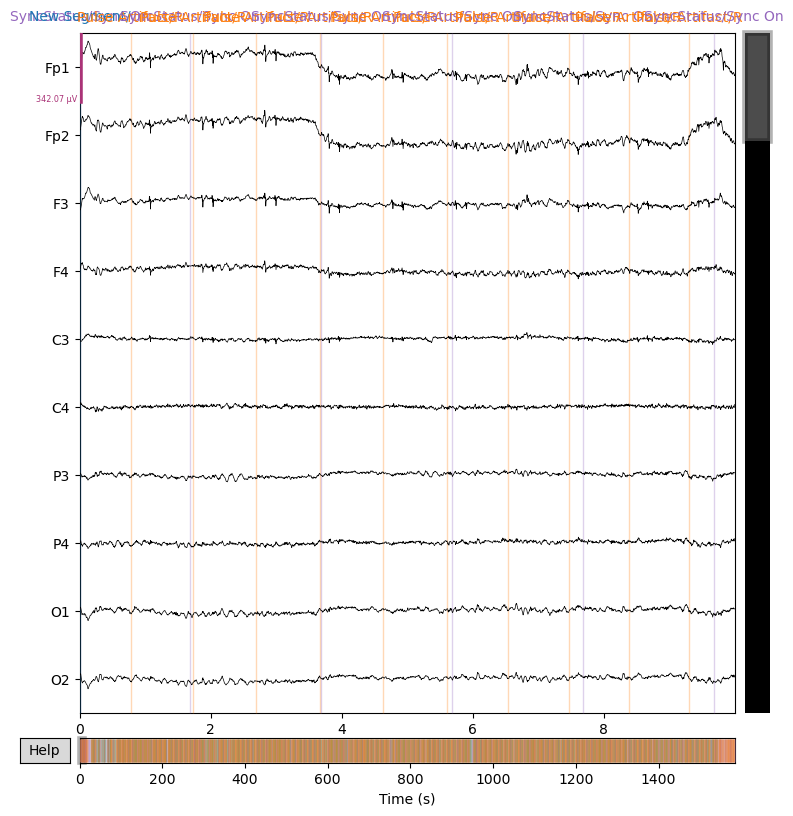

In [8]:
# Visualiing the data
raw.plot(n_channels=10, duration=10, scalings='auto')

# Computing Power Spectral Density (PSD)
This step shows how much power exists in different brain wave frequencies
(delta, theta, alpha, beta).



### Alpha Band Power Analysis

The alpha band (8–12 Hz) reflects relaxed awake brain activity. 

Here, we compute the **power spectral density (PSD)** of all EEG channels in the alpha range, then take the average across frequencies to get **one alpha power value per channel**. 

This allows us to compare which brain regions show stronger alpha activity.

In [9]:
psds = raw.copy().compute_psd(fmin=8, fmax=12).get_data()
alpha_power = psds.mean(axis=1)  # average over channels
print("Alpha power per channel:", alpha_power)

Effective window size : 8.192 (s)
Alpha power per channel: [1.01292330e-11 1.04596594e-11 4.00930159e-12 3.96262218e-12
 7.91861722e-13 1.13793963e-12 2.20749653e-12 1.94548013e-12
 4.03825756e-12 3.85008958e-12 4.24720912e-12 3.64875806e-12
 6.21395352e-12 1.61317107e-12 8.35585536e-12 2.21553215e-12
 3.35697712e-12 9.08344128e-13 2.01999410e-12 3.75158057e-12
 1.83418636e-12 2.20440951e-12 1.88751870e-12 9.33396188e-13
 1.20812971e-12 1.93077479e-12 3.10814270e-12 2.29417583e-12
 1.25307523e-11 2.84965771e-12 3.50337115e-12 3.48270917e-12
 3.92500967e-12 1.18756749e-12 1.12930422e-12 1.72874599e-12
 8.92587489e-13 4.58161215e-12 9.68745659e-12 1.34927252e-12
 1.52886810e-12 1.36235421e-12 1.24788125e-12 3.79229945e-12
 3.59191613e-12 2.93914097e-12 3.70538890e-12 1.78080553e-12
 1.17445228e-12 3.14856839e-12 2.31883872e-12 5.63739163e-12
 5.92571573e-12 1.92553142e-12 3.19868744e-12 8.16483391e-12
 1.87876544e-12 4.30919618e-12 4.00316069e-12 4.19759128e-12
 3.17877779e-12 1.07215061

Not setting metadata
1583 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1583 events and 500 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows


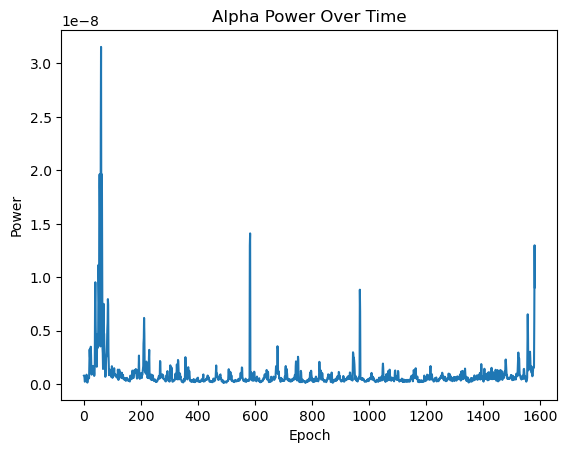

In [10]:
epochs = mne.make_fixed_length_epochs(raw, duration=2.0, overlap=1.0, preload=True)
alpha_power_epochs = epochs.compute_psd(fmin=8, fmax=12).get_data().mean(axis=(1,2))

import matplotlib.pyplot as plt
plt.plot(alpha_power_epochs)
plt.title("Alpha Power Over Time")
plt.xlabel("Epoch")
plt.ylabel("Power")
plt.show()

### Beta Band Power Analysis

The beta band (12–30 Hz) reflects brain activity related to alertness and active thinking.

Here, we compute the **power spectral density (PSD)** of all EEG channels in the beta range, then take the average across frequencies to get **one beta power value per channel**. 

This allows us to see which brain regions are more active during alert states.

In [11]:
# Make a copy of the raw data to avoid changing the original
raw_copy = raw.copy()

# Compute Power Spectral Density (PSD) for beta band (12-30 Hz)
psds_beta = raw_copy.compute_psd(fmin=12, fmax=30).get_data()

# Average over frequencies to get one number per channel
beta_power = psds_beta.mean(axis=1)

# Print results
print("Beta power per channel:", beta_power)

Effective window size : 8.192 (s)
Beta power per channel: [2.32076365e-12 2.44678324e-12 9.38914097e-13 1.14275231e-12
 4.29535554e-13 4.98964337e-13 4.95820778e-13 4.78098201e-13
 7.29057931e-13 8.97659535e-13 1.72665578e-12 1.50085405e-12
 2.86930023e-12 8.71328631e-13 2.68019392e-12 9.30529983e-13
 7.51951114e-13 3.16197509e-13 4.22872535e-13 6.32652400e-13
 5.02041049e-13 5.86430963e-13 4.02042199e-13 2.89945171e-13
 6.99672820e-13 8.34403541e-13 9.07876344e-13 7.41254590e-13
 3.06281434e-12 1.12647570e-12 7.60031767e-13 1.58288252e-12
 1.58648886e-12 9.14909986e-13 7.53159947e-13 8.10620235e-13
 6.08604241e-13 1.31973531e-12 2.38812141e-12 6.61864435e-13
 6.85263404e-13 5.16374502e-13 4.59418332e-13 7.00302952e-13
 6.80801298e-13 7.22727434e-13 1.16855814e-12 7.70231499e-13
 4.75791499e-13 7.45115342e-13 6.73120969e-13 1.71608498e-12
 1.64576146e-12 1.15532943e-12 1.47675265e-12 3.34379146e-12
 1.11916520e-12 1.28071792e-12 1.29934245e-12 2.40606715e-12
 1.91262360e-12 3.19091947e

### Beta Power Over Time

Here, we use the same 2-second overlapping epochs to observe changes in beta activity (12–30 Hz), which reflects alertness and active thinking.

We compute the average beta power for each epoch across all channels and plot it. The resulting graph shows how brain activity related to attention and focus fluctuates during the recording.

    Using multitaper spectrum estimation with 7 DPSS windows


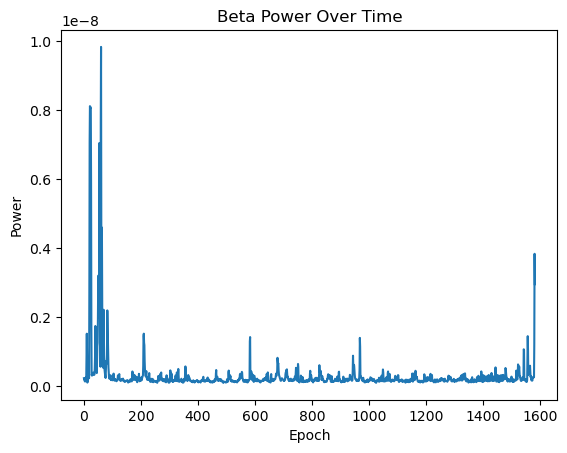

In [13]:
# Compute beta band power (12-30 Hz) for each epoch
beta_power_epochs = epochs.compute_psd(fmin=12, fmax=30).get_data().mean(axis=(1,2))

# Plotting band power over time
import matplotlib.pyplot as plt
plt.plot(beta_power_epochs)
plt.title("Beta Power Over Time")
plt.xlabel("Epoch")
plt.ylabel("Power")
plt.show()

### Theta Band Power per Channel

Theta waves (4–8 Hz) reflect drowsiness, light sleep, or memory-related processing.

Here, we compute the **power spectral density (PSD)** of each EEG channel in the theta range, then average over frequencies to get **one theta power value per channel**.

This allows us to see which brain regions show higher theta activity.

In [14]:
# Making a copy to keep the original data intact
raw_copy = raw.copy()

# Compute theta band (4-8 Hz) PSD
psd_theta = raw_copy.compute_psd(fmin=4, fmax=8).get_data()

# Average over frequencies for each channel
theta_power = psd_theta.mean(axis=1)

# Print result
print("Theta power per channel:", theta_power)

Effective window size : 8.192 (s)
Theta power per channel: [2.18528055e-11 1.42120329e-11 1.09535420e-11 5.15266783e-12
 2.38522439e-12 2.91697430e-12 5.05845972e-12 4.09812320e-12
 9.50509226e-12 7.70986417e-12 2.29339527e-11 1.05027561e-11
 1.38833593e-11 5.18812225e-12 1.46312878e-11 4.98258386e-12
 5.17258893e-12 2.48472280e-12 7.96491645e-12 8.49359388e-12
 3.81449452e-12 3.54355685e-12 7.18044154e-12 3.21890704e-12
 6.68060002e-12 4.98859660e-12 4.06951137e-12 4.82049136e-12
 1.94073842e-11 5.80630262e-12 6.66421678e-12 6.90765069e-12
 5.45996670e-12 2.97838736e-12 2.98954886e-12 5.19136915e-12
 3.51362159e-12 1.14324427e-11 1.36789724e-11 4.67040157e-12
 3.29376347e-12 3.42501655e-12 3.02143683e-12 7.43302374e-12
 5.87826168e-12 1.05842460e-11 7.02834546e-12 2.64498811e-12
 3.31144832e-12 4.68089765e-12 4.20179520e-12 2.21068331e-11
 1.01293541e-11 1.09613380e-11 7.48338026e-12 1.56397492e-11
 4.53714032e-12 6.80596386e-12 9.08528370e-12 2.45293720e-11
 8.23166530e-12 1.58531415

### Theta Power Over Time

Here, we use the same 2-second overlapping epochs to observe changes in theta activity (4-8Hz), which reflects light sleep and memory related brain activity.

We compute the average beta power for each epoch across all channels and plot it.

    Using multitaper spectrum estimation with 7 DPSS windows


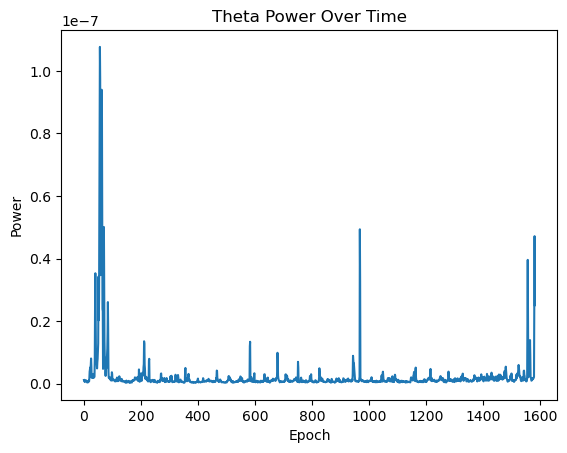

In [15]:
# Compute theta band power (4-8 Hz) for each epoch
theta_power_epochs = epochs.compute_psd(fmin=4, fmax=8).get_data().mean(axis=(1,2))

import matplotlib.pyplot as plt

plt.plot(theta_power_epochs)
plt.title("Theta Power Over Time")
plt.xlabel("Epoch")
plt.ylabel("Power")
plt.show()

### Delta Band Power per Channel

Delta waves (0.5–4 Hz) are associated with deep sleep and very slow brain activity.  

Here, we compute the **power spectral density (PSD)** for each EEG channel in the delta range, then average over frequencies to get **one delta power value per channel**.  

This allows us to see which channels show stronger deep sleep activity.

In [16]:
# Make a copy to keep original raw data intact
raw_copy = raw.copy()

# Compute PSD for delta band (0.5-4 Hz)
psd_delta = raw_copy.compute_psd(fmin=0.5, fmax=4).get_data()

# Average over frequencies for each channel
delta_power = psd_delta.mean(axis=1)

# Print result
print("Delta power per channel:", delta_power)

Effective window size : 8.192 (s)
Delta power per channel: [8.48355994e-11 6.46797298e-11 4.33938407e-11 2.74712028e-11
 1.19877733e-11 1.38976348e-11 1.61753010e-11 1.51195847e-11
 2.54229119e-11 2.16651965e-11 1.14864542e-10 6.61131203e-11
 8.49780676e-11 2.68495271e-11 7.26290426e-11 2.43406012e-11
 2.17142336e-11 1.44014338e-11 2.65640035e-11 2.34051993e-11
 1.76756658e-11 1.64472045e-11 2.50054705e-11 1.32919261e-11
 3.28689326e-11 3.15903767e-11 1.40549166e-11 1.63482209e-11
 6.56469088e-11 2.90645834e-11 1.85303027e-11 2.73490753e-11
 2.56120084e-11 1.66700245e-11 1.43615593e-11 1.81766702e-11
 1.34481322e-11 4.30862742e-11 6.32177121e-11 2.14720665e-11
 1.67491962e-11 1.37283108e-11 1.17040424e-11 2.14526078e-11
 1.73859290e-11 4.87526240e-11 3.47137965e-11 1.16994835e-11
 1.39074424e-11 1.54162826e-11 1.39630964e-11 9.83661885e-11
 5.36350576e-11 7.51827734e-11 4.62329574e-11 8.44086928e-11
 2.33784377e-11 2.10911084e-11 2.87077885e-11 1.19454111e-10
 4.92845075e-11 6.61865887

### Delta power over time

We divide the continuous EEG into 2-second epochs with 1-second overlap and for each 2-second epoch, we compute the **average delta power across all channels and frequencies**.  

This gives a time series showing how delta activity fluctuates during the recording giving a dynamic view of slow-wave brain activity.

Not setting metadata
1583 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1583 events and 500 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows


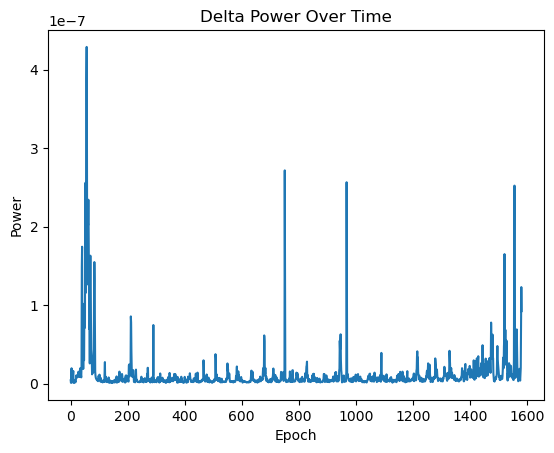

In [17]:
# Split EEG into 2-second epochs with 1-second overlap
epochs = mne.make_fixed_length_epochs(raw, duration=2.0, overlap=1.0, preload=True)
# Compute delta power for each epoch
delta_power_epochs = epochs.compute_psd(fmin=0.5, fmax=4).get_data().mean(axis=(1,2))

import matplotlib.pyplot as plt

plt.plot(delta_power_epochs)
plt.title("Delta Power Over Time")
plt.xlabel("Epoch")
plt.ylabel("Power")
plt.show()

### Comparison of EEG Band Power Over Time

This plot shows all four EEG bands together:

- **Delta (0.5–4 Hz):** deep sleep / slow waves  
- **Theta (4–8 Hz):** drowsiness / light sleep  
- **Alpha (8–12 Hz):** relaxed awake state  
- **Beta (12–30 Hz):** alert / active thinking  

By plotting them together, we can **compare fluctuations** and **see which brain states dominate at different times**.

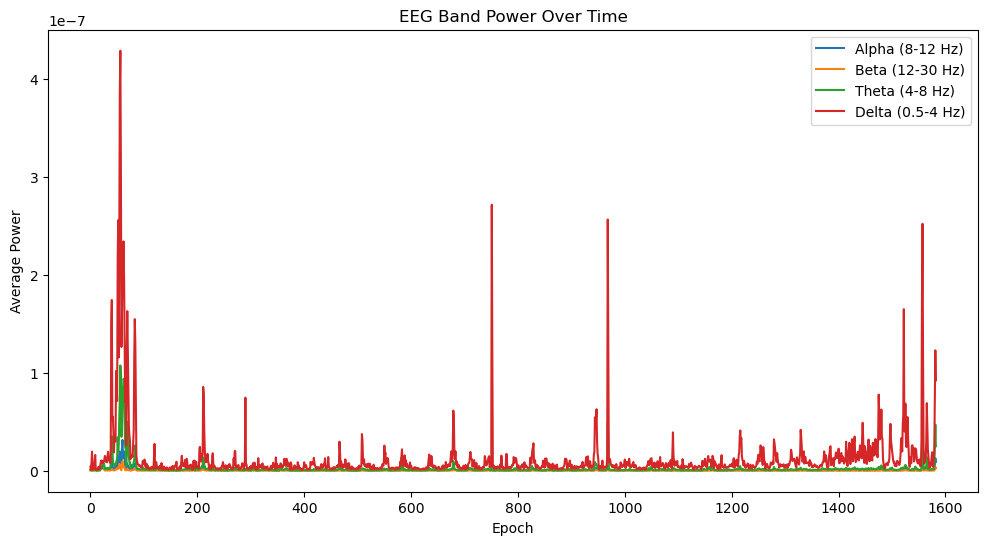

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

plt.plot(alpha_power_epochs, label="Alpha (8-12 Hz)")
plt.plot(beta_power_epochs, label="Beta (12-30 Hz)")
plt.plot(theta_power_epochs, label="Theta (4-8 Hz)")
plt.plot(delta_power_epochs, label="Delta (0.5-4 Hz)")

plt.title("EEG Band Power Over Time")
plt.xlabel("Epoch")
plt.ylabel("Average Power")
plt.legend()
plt.show()

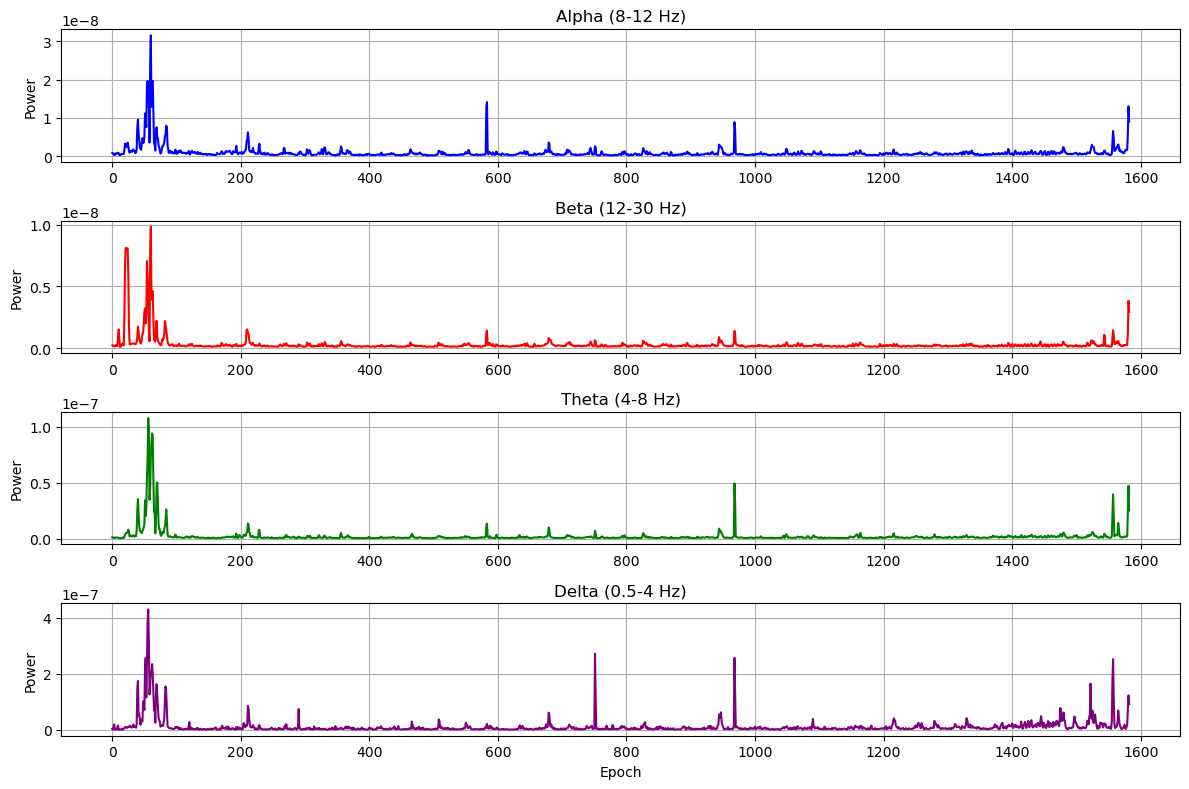

In [25]:
plt.figure(figsize=(12,8))


plt.subplot(4,1,1)
plt.grid()
plt.plot(alpha_power_epochs, color='blue')
plt.title("Alpha (8-12 Hz)")
plt.ylabel("Power")

plt.subplot(4,1,2)
plt.grid()
plt.plot(beta_power_epochs, color='red')
plt.title("Beta (12-30 Hz)")
plt.ylabel("Power")

plt.subplot(4,1,3)
plt.grid()
plt.plot(theta_power_epochs, color='green')
plt.title("Theta (4-8 Hz)")
plt.ylabel("Power")

plt.subplot(4,1,4)
plt.grid()
plt.plot(delta_power_epochs, color='purple')
plt.title("Delta (0.5-4 Hz)")
plt.xlabel("Epoch")
plt.ylabel("Power")

plt.tight_layout()
plt.show()